In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BBBSBBBB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    348.1| 42.3833|    -72.4|       PRCP|USC00196256|     6|[00 00 00 00 00 7...|1956.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       PRCP|USC00198301|     1|[00 00 00 00 00 0...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       PRCP|USC00198301|     4|[00 00 4C 61 20 5...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       PRCP|USC00198301|    12|[00 00 00 00 00 0...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       PRCP|USC00198301|    20|[00 48 80 4A 00 7...|1934.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [7]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(3801, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

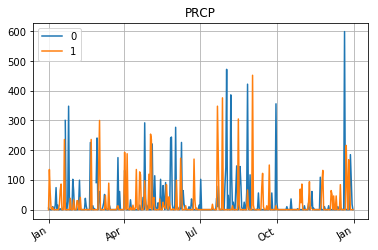

In [8]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

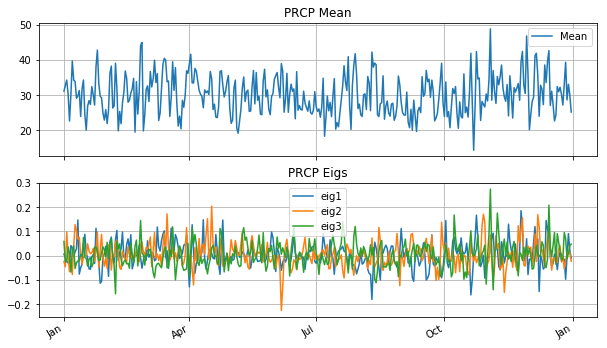

In [9]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

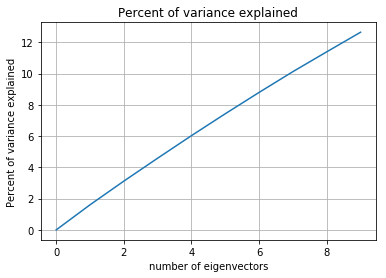

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [11]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.899734424458
residual normalized norm  after mean + top eigs: [ 0.99204288  0.97952777  0.97224881]


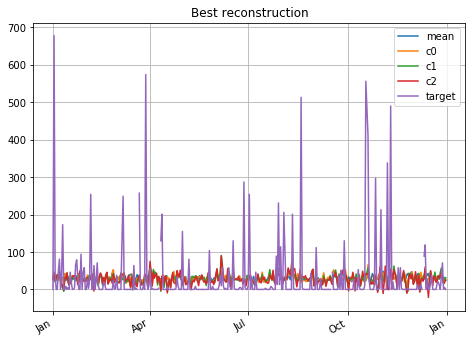

Widget Javascript not detected.  It may not be installed or enabled properly.


In [12]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [13]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [14]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 3801
after filter 3797


In [15]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [16]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [17]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.8467769439968627|0.5959032466281545|0.5817312908947456|  0.57553411389937|
|0.8276688155199715|0.6160860525878636|0.5990759945326409|0.5917311578504297|
| 0.830444630305502|0.6244316103374467|0.6000982800761732|0.5979267162086033|
|0.8327772993437904|0.6243609790818773|0.6067192407498386|0.5995771886243688|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


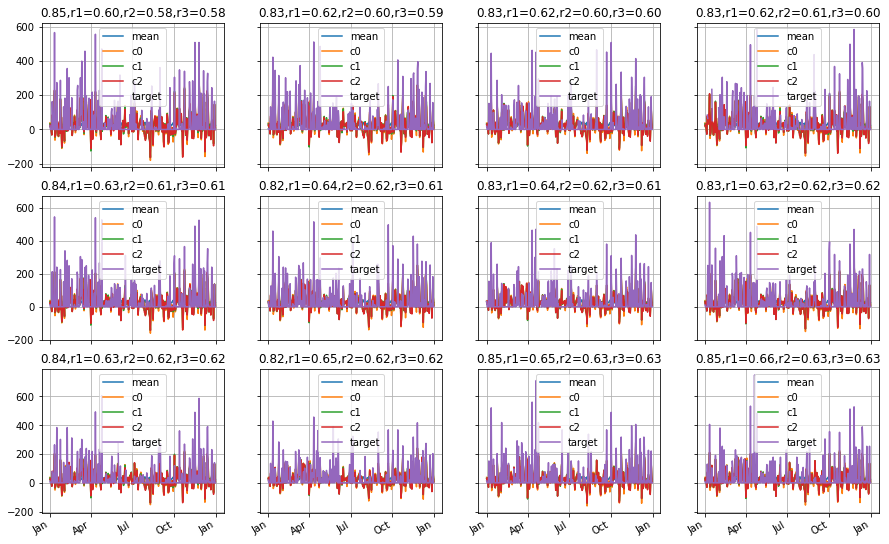

In [18]:
plot_recon_grid(rows)

In [19]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.8922354013978101|1.0000134739454434| 0.999982692269769| 1.000270352986945|
|0.8898983235865761|0.9999691659870645|1.0000083808286164| 1.000159237965781|
|0.9082238341582072|1.0000529914732323|  1.00005765158852|1.0000135079018835|
|0.8552896590844503| 0.999831387298397| 0.999889081615709| 0.999973641422067|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



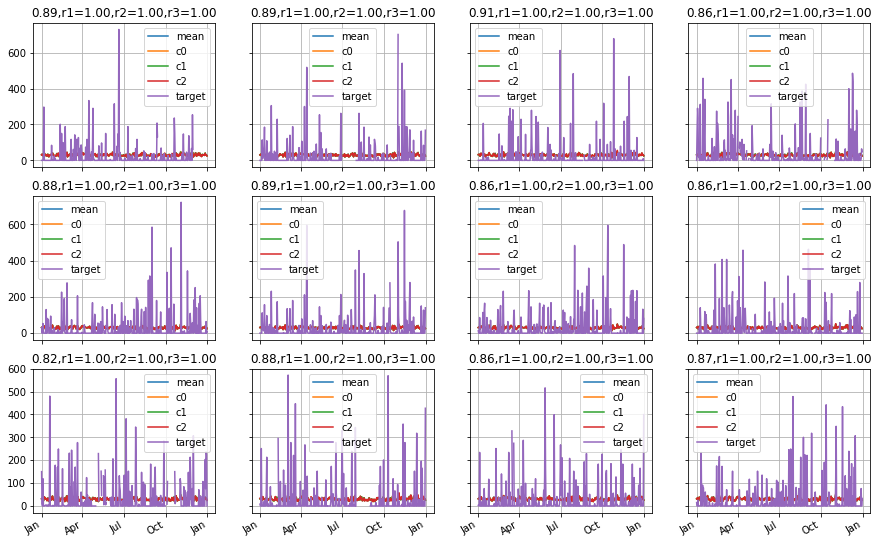

In [20]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

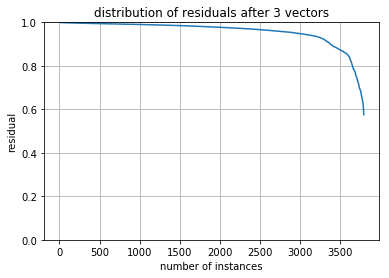

In [21]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [22]:
rows=df3.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[10]

(u'USC00199360',
 1906.0,
 array([   3.,    0.,    5.,  234.,    0.,   18.,    0.,    0.,   18.,
           0.,    0.,   38.,    0.,   76.,    0.,   33.,    0.,   23.,
           0.,    0.,    0.,    0.,    0.,  117.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   10.,
           0.,    0.,    0.,  251.,    0.,    0.,    0.,    8.,   23.,
          38.,    0.,    0.,    0.,    0.,    0.,  140.,   33.,    0.,
           0.,    0.,   41.,    0.,    0.,    0.,    0.,  109.,   13.,
           0.,    0.,    0.,    0.,  234.,   10.,    0.,   61.,    0.,
           0.,   nan,  328.,    0.,    0.,   nan,  274.,    0.,    0.,
           0.,    0.,    0.,    5.,   33.,    0.,    0.,   74.,   38.,
           0.,    0.,    0.,    8.,    0.,   86.,    0.,    0.,   13.,
         287.,   56.,    0.,    0.,    0.,   99.,    0.,    0.,    0.,
           0.,    0.,    0.,    3.,   30.,    0.,    0.,    0.,    0.,
           0.,    0.,   76.,    0.,   51.,    0.,  

In [23]:
years=set([r[1] for r in rows])
miny=min(years)
maxy=max(years)
record_len=int((maxy-miny+1)*365)
record_len

46720

In [24]:
All={}  # a dictionary with a numpy array for each day of each year
i=0
for station,year,vector in rows:
    i+=1; 
    if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((year-miny)*365)
    All[station][loc:loc+365]=vector

1000 114
2000 126
3000 135


In [25]:
All.keys()[:5]

[u'USC00192812',
 u'USC00193890',
 u'USC00192150',
 u'USW00014753',
 u'USC00191622']

In [26]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [27]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00192812 354
USC00193890 9946
USC00192150 5436
USW00014753 43051
USC00191622 16248
USC00193224 1459
USC00193229 2488
USC00198580 26731
USC00194125 999
USC00190593 5723
USC00190595 1072
USC00193702 28237
USC00196699 14430
USC00192806 29192
USC00190535 18495
USC00190538 6867
USC00191323 1091
USC00198757 14530
US1MAWR0001 1312
USC00198755 8379
USC00199226 3941
USC00197104 3209
USC00190801 20452
USC00190120 40335
USC00196915 5694
USC00193625 10556
USC00193624 18877
USC00194135 14966
USC00196720 363
USC00199093 332
USC00198218 364
USC00193429 354
USC00196993 2386
USC00195060 1813
USC00195390 4218
US1MAWR0013 365
USW00094746 23318
USC00198030 24771
USW00014739 28077
USC00195095 4304
USW00054756 5036
USC00193940 705
USC00195177 318
USC00195524 17383
US1MAMD0011 342
US1MAES0008 1070
USC00195077 365
USC00198301 9296
USC00190551 18723
USC00195175 11931
US1MAES0002 1041
USC00199080 10218
USC00194760 25782
USC00191097 6520
USC00192107 18125
USC00194154 725
USC00193110 986
USC00191099 2120
USC00

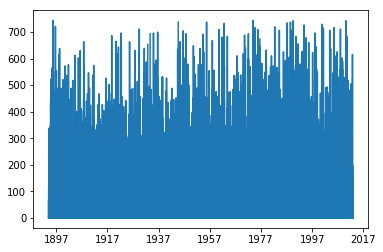

In [28]:
plot(dates,All['USW00014753'])

In [299]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

T=np.hstack([A])
print shape(T)

(140, 46720)


In [300]:
Mean_Across_Time=np.nanmean(T,1)
total_RMS=sqrt(np.nanmean(T**2))
RT=T.transpose()-Mean_Across_Time
RT=RT.transpose()
Reduced_RMS=sqrt(np.nanmean(RT**2))
print 'after removing mean across time:'
print 'total_RMS=%f, Reduced_RMS=%f, reduction ratio=%f'%(total_RMS,Reduced_RMS,Reduced_RMS/total_RMS)

after removing mean across time:
total_RMS=83.739180, Reduced_RMS=78.128439, reduction ratio=0.932997


In [301]:
Mean_Across_Stations=np.nanmean(RT,0)
total_RMS=sqrt(np.nanmean(RT**2))
RTS=RT-Mean_Across_Stations
Reduced_RMS=sqrt(np.nanmean(RTS**2))
print 'after removing mean across time and mean across stations:'
print 'total_RMS=%f, Reduced_RMS=%f, reduction ratio=%f'%(total_RMS,Reduced_RMS,Reduced_RMS/total_RMS)

after removing mean across time and mean across stations:
total_RMS=78.128439, Reduced_RMS=50.060768, reduction ratio=0.640750


/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [302]:
F=RT.flatten()
NN=F[~np.isnan(F)]
NZ=NN[NN>0]
shape(F),shape(NN),shape(NZ)

((6540800,), (1359559,), (267000,))

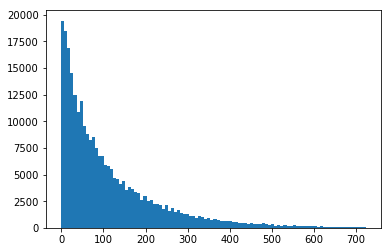

In [303]:
hist(NZ,bins=100);

In [304]:
#Normalize rows of RT to have norm 1
Len=sqrt(np.nansum(RT**2,axis=1))
NRT=(RT.transpose()/Len).transpose()

In [305]:
K=5
n,m=T.shape
TK=np.empty([n*K,m-K],dtype=numpy.float64)
Middle=K/2
for i in range(K):
    TK[i::K,:]=NRT[:,i:-K+i]

TKnan=np.isnan(TK)
TK[TKnan]=0
TK1nan=1-TKnan*1

TT=NRT[:,Middle:-Middle-1]
TTnan=np.isnan(TT)
TT1nan=1-TTnan*1
TT[TTnan]=0
print TK.shape,TT.shape
print sum(TK1nan,axis=1)
print sum(TT1nan)

(700, 46715) (140, 46715)
[ 1036  1037  1038  1039  1040  1068  1068  1068  1069  1070   982   983
   984   985   986   337   338   339   340   341   719   720   721   722
   723  1086  1087  1088  1089  1090   721   722   723   724   725  1307
  1308  1309  1310  1311   360   361   362   363   364 40330 40331 40332
 40333 40334  2525  2525  2525  2525  2525 23668 23668 23668 23668 23668
  9755  9755  9755  9755  9755 19589 19590 19591 19592 19593 18495 18495
 18495 18495 18495  6867  6867  6867  6867  6867 18723 18723 18723 18723
 18723 25651 25652 25653 25653 25653   680   680   680   680   680  5718
  5719  5720  5721  5722  1072  1072  1072  1072  1072   353   353   353
   353   353  2785  2785  2785  2785  2785 20452 20452 20452 20452 20452
 16028 16029 16030 16031 16032  6520  6520  6520  6520  6520  2120  2120
  2120  2120  2120   365   365   365   365   365  1091  1091  1091  1091
  1091  1418  1418  1418  1418  1418 32657 32657 32657 32657 32657 23536
 23536 23536 23536 23536 

In [306]:
Prod=np.dot(TK,TT.transpose())
print shape(Prod)
print sum(np.isnan(Prod.flatten()))

(700, 140)
0


In [307]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.matshow(mat)

(140, 46715) (700, 46715)
0
(700, 140)
53116


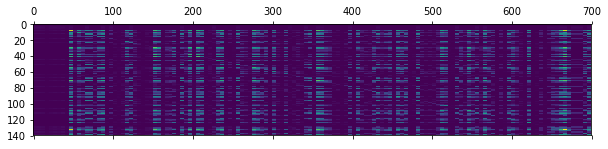

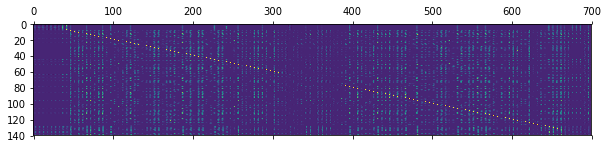

In [308]:
print shape(TT1nan),shape(TK1nan)
print sum(np.isnan(TT.flatten()))
Count=np.dot(TK1nan,TT1nan.transpose())
print shape(Count)
print sum(Count.flatten()==0)
showmat(Count.transpose())
showmat(Prod.transpose())

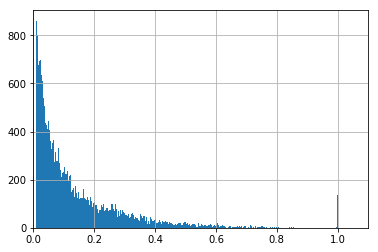

In [312]:
hist(Prod[Prod>0.01].flatten(),bins=300);
xlim([0.0,1.1])
grid()
#showmat(ProdMean[:100,:100].transpose())

In [201]:
n,m

(140, 46720)

In [313]:
_shift=np.empty([n,n])
_max=np.empty([n,n])
for i in range(n):
    Slice=Prod[i*K:(i+1)*K,:]
    _shift[i,:]=argmax(Slice,axis=0)
    _max[i,:]=np.max(Slice,axis=0)

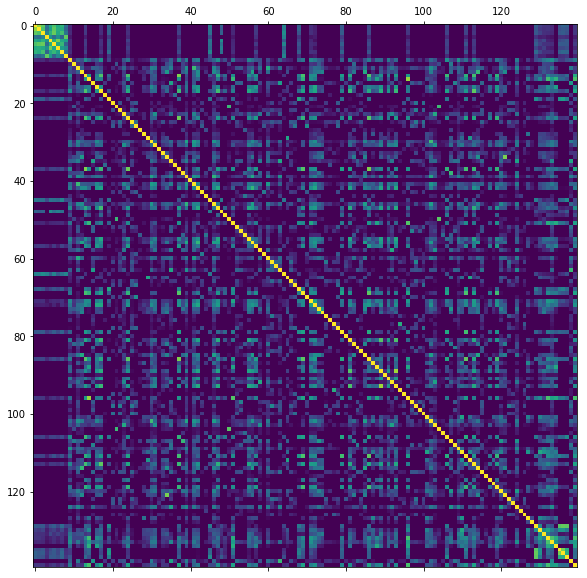

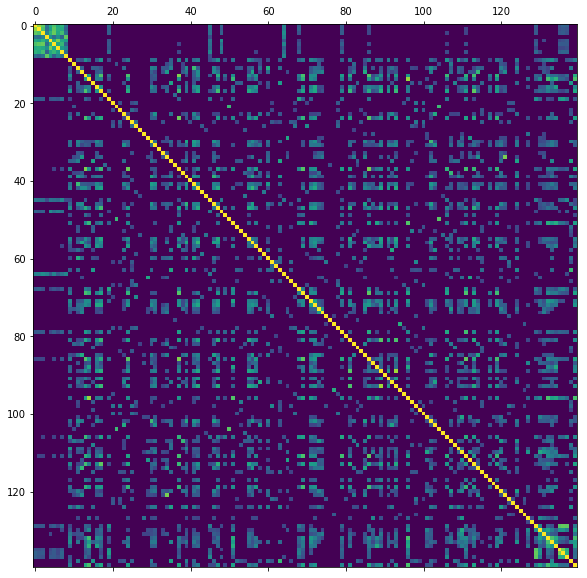

In [351]:
showmat(_max)
showmat(_max*(_max>0.2))

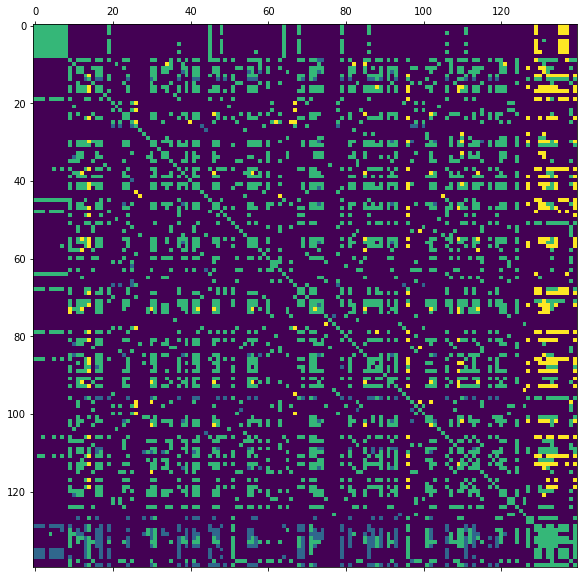

In [352]:
_Sshift=_shift*(_max>0.2)
showmat(_Sshift)

In [350]:
print min(_Sshift.flatten()),max(_Sshift.flatten())

0.0 3.0


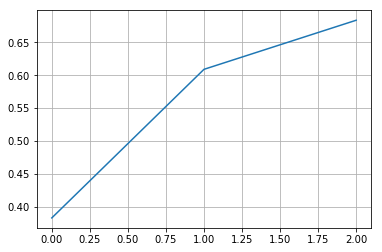

In [330]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
pca.fit(_max)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(cumsum(Var_explained))
grid()

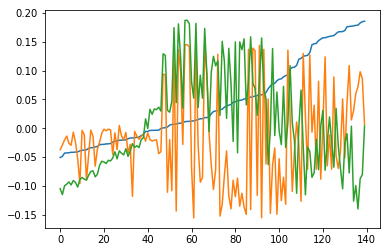

In [334]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[0]) 
plot(X);
#(key=lambda x:x[0])

In [329]:
len(X)

140

(10, 140)


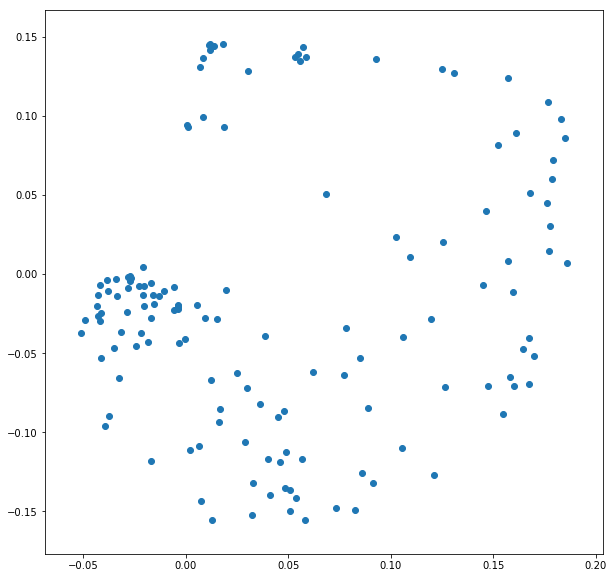

In [324]:
comp_=pca.components_
figure(figsize=(10,10))
print shape(comp_)
scatter(comp_[0,:],comp_[1,:]);

/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


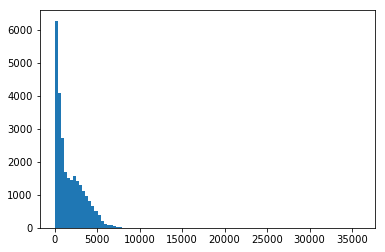

In [321]:
hist(Vals[Vals>0.1],bins=100);


In [99]:
ProdMean[600:605,605:610]

array([[ 0.34083926,  0.1594268 ,  0.07205932,  0.08150203,  0.08262134],
       [ 0.1736887 ,  0.34083926,  0.1594268 ,  0.07205932,  0.08150203],
       [ 0.06831935,  0.1736887 ,  0.34083926,  0.1594268 ,  0.07205932],
       [ 0.10017134,  0.06831935,  0.1736887 ,  0.34083926,  0.1594268 ],
       [ 0.08760136,  0.10017134,  0.06831935,  0.1736887 ,  0.34083926]])

In [82]:
# consider only 

670